This notebook demonstrates use of our linear approximation for a multiplicative functional perturbation 

In [31]:
import autograd 
from autograd import numpy as np
from autograd import scipy as sp

import scipy as osp

from numpy.polynomial.hermite import hermgauss

np.random.seed(453453)

import paragami

# BNP sensitivity libraries
import sys
import bnpgmm_runjingdev.gmm_clustering_lib as gmm_lib
from bnpmodeling_runjingdev import modeling_lib 
import bnpgmm_runjingdev.gmm_preconditioner_lib as precond_lib
import bnpgmm_runjingdev.gmm_cavi_lib as cavi_lib

import bnpgmm_runjingdev.functional_sensitivity_lib as fun_sens_lib 
from bnpgmm_runjingdev import utils_lib

from bnpgmm_runjingdev import hessian_lib
import bnpgmm_runjingdev.gmm_preconditioner_lib as preconditioner_lib


from bnpmodeling_runjingdev import optimization_lib 
from bnpmodeling_runjingdev import cluster_quantities_lib as cluster_lib

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA

from copy import deepcopy

import vittles
from tqdm import tqdm

import json 
import time

In [2]:
# colors for plotting
import matplotlib.cm as cm

cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(12)]
colors2 = [cmap(k * 25) for k in range(12)]

# Load data

We load and plot the iris dataset

In [3]:
# load iris data
dataset_name = 'iris'
features, iris_species = utils_lib.load_data()
dim = features.shape[1]
n_obs = len(iris_species)    

Text(0, 0.5, 'PC2')

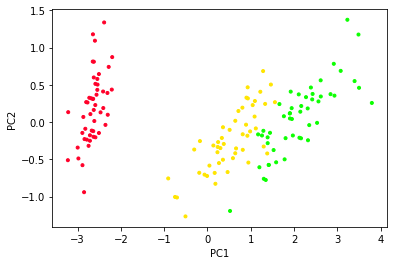

In [4]:
# run PCA
pca_fit = PCA()
pca_fit.fit(features)
pc_features = pca_fit.transform(features)

# plot
cmap = cm.get_cmap(name='gist_rainbow')
colors1 = [cmap(k * 50) for k in range(30)]

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)
utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], iris_species, colors1, fig)
fig.set_xlabel('PC1')
fig.set_ylabel('PC2')


# Load model

### Get prior 

In [5]:
prior_params_dict, prior_params_paragami = gmm_lib.get_default_prior_params(dim)

In [6]:
print(prior_params_dict)

{'alpha': array([3.]), 'prior_centroid_mean': array([0.]), 'prior_lambda': array([1.]), 'prior_wishart_df': array([10.]), 'prior_wishart_rate': array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])}


In [7]:
# DP prior parameter 
prior_params_dict['alpha'] = 12.

### Variational parameters

In [8]:
k_approx = 30

In [9]:
# Gauss-Hermite points
gh_deg = 20
gh_loc, gh_weights = hermgauss(gh_deg)

In [10]:
# get vb parameters
vb_params_dict, vb_params_paragami = gmm_lib.get_vb_params_paragami_object(dim, k_approx)

In [11]:
# the objective 
gmm_lib.get_kl(features, vb_params_dict, prior_params_dict, gh_loc, gh_weights)

2009.3998815516827

# Optimize

### Kmeans

In [12]:
# run a kmeans init
n_kmeans_init = 10
init_vb_free_params, init_vb_params_dict, init_ez = \
    utils_lib.cluster_and_get_k_means_inits(features, vb_params_paragami, 
                                                n_kmeans_init = n_kmeans_init, 
                                                seed = 3445)
                                                
print('initial kl: ')
print(gmm_lib.get_kl(features, init_vb_params_dict, prior_params_dict, gh_loc, gh_weights))

initial kl: 
6947.284936070855


## Run CAVI

In [13]:
x_tol = 1e-3

In [14]:
vb_params_dict = deepcopy(init_vb_params_dict)

In [15]:
vb_cavi_dict, ez_cavi = cavi_lib.run_cavi(features, vb_params_dict,
                                            vb_params_paragami, prior_params_dict,
                                            gh_loc, gh_weights,
                                            debug = False, 
                                         x_tol = x_tol)

done. num iterations = 119
stick_time: 0.658sec
cluster_time: 0.055sec
e_z_time: 0.161sec
**TOTAL time: 1.947sec**


In [16]:
def plot_results_from_vb_params_dict(pca_fit, vb_params_dict, e_z, fig): 
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, vb_params_dict['cluster_params']['centroids'], 
                                               np.linalg.inv(vb_params_dict['cluster_params']['cluster_info']))
    
    bnp_clusters = np.argmax(e_z, axis = 1)
    
    cmap = cm.get_cmap(name='gist_rainbow')
    colors1 = [cmap(k * 50) for k in range(30)]

    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
                  colors1, fig, \
                  centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], 
                cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])


Text(0, 0.5, 'PC2')

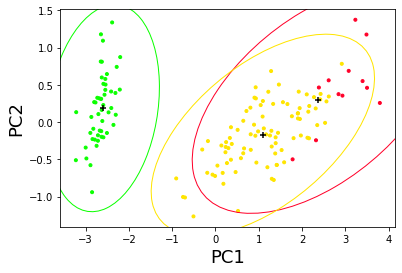

In [17]:
fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

plot_results_from_vb_params_dict(pca_fit, vb_cavi_dict, ez_cavi, fig)
fig.set_xlabel('PC1', fontsize = 18)
fig.set_ylabel('PC2', fontsize = 18)


In [18]:
vb_cavi_free = vb_params_paragami.flatten(vb_cavi_dict, free = True)

## A few more Newton steps; for comparison later

In [19]:
continue_with_newton = True

In [20]:
if continue_with_newton: 
    
    get_vb_params_loss = paragami.FlattenFunctionInput(
                                original_fun=gmm_lib.get_kl, 
                                patterns = vb_params_paragami,
                                free = True,
                                argnums = 1)

    get_loss_objective = \
        paragami.OptimizationObjective(lambda x : \
                                       get_vb_params_loss(features, x, prior_params_dict, gh_loc, gh_weights))
    
    res = osp.optimize.minimize(
                fun=get_loss_objective.f,
                jac=get_loss_objective.grad,
                hessp=get_loss_objective.hessian_vector_product,
                x0=deepcopy(vb_cavi_free), 
                method='trust-ncg', options={'disp':True})
    
    
    print('\nlinf diff in vb_params: ', np.abs(res.x - vb_cavi_free).max())
    
    vb_newton_free = deepcopy(res.x)
    vb_newton_dict = vb_params_paragami.fold(vb_newton_free, free = True)
    ez_newton = gmm_lib.get_optimal_z_from_vb_params_dict(features, vb_newton_dict,
                                                        gh_loc, gh_weights)


Iter 0: f = -318.52251934
Iter 1: f = -318.52264234
Iter 2: f = -318.52264239
Optimization terminated successfully.
         Current function value: -318.522642
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 82

linf diff in vb_params:  0.020896004879003005


# Define a perturbation in the logit v space.

In [56]:
def log_phi(logit_v):
    return(sp.special.expit(logit_v))

def phi(logit_v):
    return np.exp(log_phi(logit_v))


In [57]:
logit_v_grid = np.linspace(-8, 8, 200)

v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

print('phi max: ', np.max(phi(logit_v_grid)))
log_phi_max = np.max(np.abs(np.log(phi(logit_v_grid))))
print('log phi max: ', log_phi_max)

def rescaled_log_phi(logit_v):
    return 10 * log_phi(logit_v) / log_phi_max


phi max:  2.717370405124736
log phi max:  0.9996646498695336


In [58]:
prior_perturbation = fun_sens_lib.PriorPerturbation(
                                alpha0 = prior_params_dict['alpha'],
                                log_phi = rescaled_log_phi, 
                                logit_v_ub=8, logit_v_lb = -8)

print(
    prior_perturbation.log_norm_p0,
    prior_perturbation.log_norm_pc,
    prior_perturbation.log_norm_p0_logit,
    prior_perturbation.log_norm_pc_logit)

-2.4849066497879995 1.1634968823127927 -2.4889315240780148 1.1662640532746475


Text(0.5, 1.0, 'Priors in logit space')

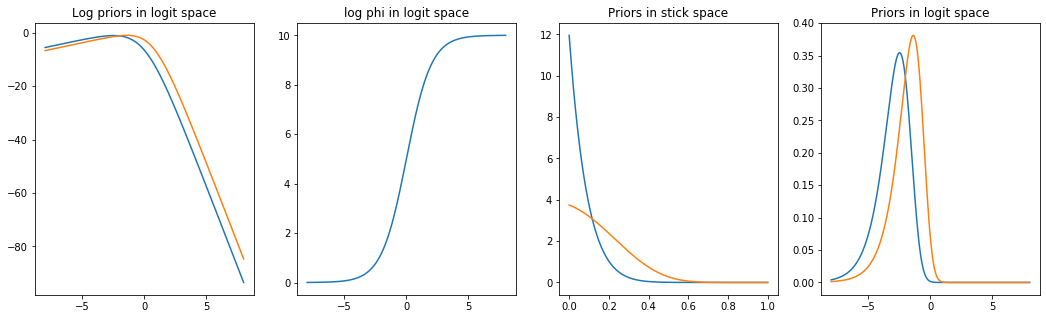

In [59]:
prior_perturbation.set_epsilon(1.0)

plt.figure(1, figsize=(18, 5))

plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid))
plt.title('log phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


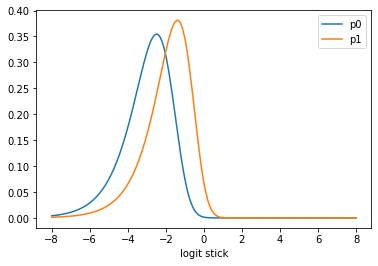

In [60]:
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)), label = 'p0')
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)), label = 'p1')
plt.xlabel('logit stick')
plt.legend()

# Define prior perturbation

In [61]:
# we will use this for the sensitivity class
get_epsilon_vb_loss = paragami.FlattenFunctionInput(
    lambda params, epsilon: fun_sens_lib.get_perturbed_kl(
                                                        features, 
                                                        params,
                                                        epsilon,
                                                        rescaled_log_phi,
                                                        prior_params_dict, 
                                                        gh_loc, gh_weights),
    argnums=0, patterns=vb_params_paragami, free=True)
    
hyper_par_objective_fun = paragami.FlattenFunctionInput(
    lambda params, epsilon: fun_sens_lib.get_e_log_perturbation(
                                                                rescaled_log_phi, 
                                                                params,
                                                                epsilon,
                                                                gh_loc, gh_weights),
    argnums=0, patterns=vb_params_paragami, free=True)

In [33]:
epsilon0 = np.array([0.])

In [34]:
def get_nystrom_preconditioner(vb_opt, e_z_opt): 
    k_large = 5
    which_k = np.argsort(-e_z_opt.mean(0))[0:k_large]

    sub_block_hess, indx = hessian_lib.get_large_clusters_hessian(features, which_k, vb_opt, vb_params_paragami, 
                                                                      prior_params_dict, gh_loc, gh_weights)

    est_lambda_max = np.abs(sub_block_hess).sum(1).max()
    nystrom_precond = preconditioner_lib.get_nystrom_woodbury_precon(sub_block_hess, indx, est_lambda_max)
    
    return nystrom_precond

In [35]:
get_full_hessian = False 

if get_full_hessian:
    hess_solver = None
else: 
    # get cg solver 
    # preconditioner = precond_lib.get_gmm_preconditioner(vb_cavi_free, vb_params_paragami)
    preconditioner = get_nystrom_preconditioner(vb_cavi_free, ez_cavi)
    obj_fun_hvp = autograd.hessian_vector_product(get_epsilon_vb_loss, argnum = 0)
    
    hess_solver = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_cavi_free, epsilon0, x), 
                                                            dim = len(vb_cavi_free), 
                                                            cg_opts={'M':preconditioner})
    
    
t0 = time.time()
epsilon_sens = \
    vittles.HyperparameterSensitivityLinearApproximation(
        objective_fun = get_epsilon_vb_loss, 
        opt_par_value = vb_cavi_free, 
        hyper_par_value = epsilon0, 
        hess_solver = hess_solver, 
        hyper_par_objective_fun = hyper_par_objective_fun)

print('derivative time: {}sec'.format(np.round(time.time() - t0, 3)))

derivative time: 7.9sec


In [37]:
if continue_with_newton: 
    
    if get_full_hessian:
        hess_solver = None
    else: 
        # get cg solver 
        # preconditioner = precond_lib.get_gmm_preconditioner(vb_newton_free, vb_params_paragami)
        preconditioner = get_nystrom_preconditioner(vb_newton_free, ez_newton)

        newton_hess_solver = vittles.solver_lib.get_cg_solver(lambda x : obj_fun_hvp(vb_newton_free, 
                                                                              epsilon0, x), 
                                                                dim = len(vb_cavi_free), 
                                                                cg_opts={'M':preconditioner})
    

    t0 = time.time()
    epsilon_sens_newton = \
        vittles.HyperparameterSensitivityLinearApproximation(
            objective_fun = get_epsilon_vb_loss, 
            opt_par_value = vb_newton_free, 
            hyper_par_value = epsilon0, 
            hess_solver = newton_hess_solver, 
            hyper_par_objective_fun = hyper_par_objective_fun)

    print('derivative time: {}sec'.format(np.round(time.time() - t0, 3)))

derivative time: 7.485sec


## Get predicted perturbation

In [38]:
epsilon = 0.1
print('Epsilon: ', epsilon)

vb_pert_pred = epsilon_sens.predict_opt_par_from_hyper_par(epsilon)

if continue_with_newton: 
    vb_pert_pred_newton = epsilon_sens_newton.predict_opt_par_from_hyper_par(epsilon)

print('Predicted differences: ', np.linalg.norm(vb_pert_pred - vb_cavi_free))

Epsilon:  0.1
Predicted differences:  0.40616254229332144


## Fit with perturbation

In [39]:
new_init_dict = deepcopy(vb_cavi_dict)
# new_init_dict = deepcopy(init_vb_params_dict)
new_init_free = vb_params_paragami.flatten(new_init_dict, free = True)

In [40]:
vb_pert_dict, e_z_pert = cavi_lib.run_cavi(features, deepcopy(new_init_dict),
                                        vb_params_paragami, prior_params_dict,
                                        gh_loc, gh_weights,
                                        log_phi = rescaled_log_phi, epsilon = epsilon, 
                                       debug = False)

vb_pert_opt = vb_params_paragami.flatten(vb_pert_dict, free = True)

done. num iterations = 34
stick_time: 0.827sec
cluster_time: 0.017sec
e_z_time: 0.048sec
**TOTAL time: 1.203sec**


## Compare LR with refitting 

In [41]:
def print_diff_plot(lr_vb_free_params, vb_pert_opt, vb_opt): 
    plt.plot(lr_vb_free_params - vb_opt, 
             vb_pert_opt - vb_opt, 
             '+', color = 'red')

    plt.plot(lr_vb_free_params - vb_opt, 
            lr_vb_free_params - vb_opt, 
             '-', color = 'blue')

    plt.xlabel('lr')
    plt.ylabel('re-optimized')

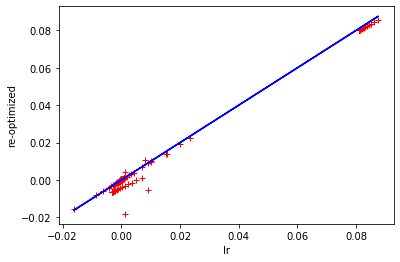

In [42]:
print_diff_plot(vb_pert_pred, vb_pert_opt, new_init_free)

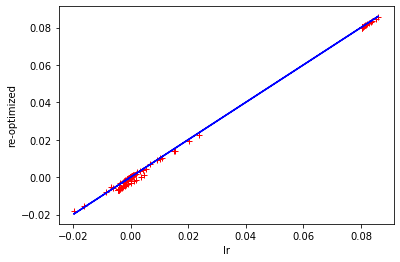

In [43]:
if continue_with_newton: 
    print_diff_plot(vb_pert_pred_newton, vb_pert_opt, new_init_free)

In [44]:
print('original expected number of clusters: ',
    cluster_lib.get_e_num_clusters_from_ez(ez_cavi))


ez_pert = gmm_lib.get_optimal_z_from_vb_params_dict(features, 
                                                   vb_params_paragami.fold(vb_pert_opt, free = True), 
                                                   gh_loc, gh_weights)
print('perturbed expected number of clusters: ',
    cluster_lib.get_e_num_clusters_from_ez(ez_pert))

ez_pert_pred = gmm_lib.get_optimal_z_from_vb_params_dict(features, 
                                                   vb_params_paragami.fold(vb_pert_pred, free = True), 
                                                   gh_loc, gh_weights)
print('predicted expected number of clusters: ',
    cluster_lib.get_e_num_clusters_from_ez(ez_pert_pred))

if continue_with_newton: 
    ez_pert_pred_newton = gmm_lib.get_optimal_z_from_vb_params_dict(features, 
                                                       vb_params_paragami.fold(vb_pert_pred_newton, free = True), 
                                                       gh_loc, gh_weights)
    print('predicted expected number of clusters (newton): ',
        cluster_lib.get_e_num_clusters_from_ez(ez_pert_pred_newton))

original expected number of clusters:  5.235524721671624
perturbed expected number of clusters:  5.169437827136701
predicted expected number of clusters:  5.17310245935759
predicted expected number of clusters (newton):  5.169486139113008


# Predict for a range of perturbations

In [45]:
# The range of epsilons we shall consider
epsilon_vec = np.linspace(0, 1, 15) ** 2 # Square to get more points close to 0
print(epsilon_vec)

[0.         0.00510204 0.02040816 0.04591837 0.08163265 0.12755102
 0.18367347 0.25       0.32653061 0.41326531 0.51020408 0.61734694
 0.73469388 0.8622449  1.        ]


In [46]:
def refit_with_epsilon(epsilon, new_init_dict):
    # sets new epsilon, returns new vb optimum

    vb_pert_dict, e_z_pert = cavi_lib.run_cavi(features, deepcopy(new_init_dict),
                                        vb_params_paragami, prior_params_dict,
                                        gh_loc, gh_weights,
                                        log_phi = rescaled_log_phi, epsilon = epsilon, 
                                       debug = False)
    
    return vb_params_paragami.flatten(vb_pert_dict, free = True)

In [47]:
vb_pert_opt_array = []
vb_pert_pred_array = []
vb_pert_pred_array_newton = []

for i in range(len(epsilon_vec)): 
    epsilon = epsilon_vec[i]
    print('\n\nEpsilon: ', epsilon)
    
    # get linear predictions
    vb_pert_pred = \
        epsilon_sens.predict_opt_par_from_hyper_par(epsilon)
    if continue_with_newton: 
        vb_pert_pred_newton = \
            epsilon_sens_newton.predict_opt_par_from_hyper_par(epsilon)
    
    # Then fit with the perturbation.
    vb_pert_opt = refit_with_epsilon(epsilon, new_init_dict)
    
    print('Predicted differences: ', np.linalg.norm(vb_pert_pred - new_init_free))
    print('Actual differences: (This is nonzero if phi did anything):',
          np.linalg.norm(vb_pert_opt - new_init_free))
    
    # save results: 
    vb_pert_opt_array.append(vb_pert_opt)
    vb_pert_pred_array.append(vb_pert_pred)
    if continue_with_newton: 
        vb_pert_pred_array_newton.append(vb_pert_pred_newton)




Epsilon:  0.0
done. num iterations = 2
stick_time: 0.083sec
cluster_time: 0.002sec
e_z_time: 0.006sec
**TOTAL time: 0.117sec**
Predicted differences:  0.0
Actual differences: (This is nonzero if phi did anything): 0.005208619721216611


Epsilon:  0.00510204081632653
done. num iterations = 11
stick_time: 0.317sec
cluster_time: 0.006sec
e_z_time: 0.016sec
**TOTAL time: 0.443sec**
Predicted differences:  0.020722578688434592
Actual differences: (This is nonzero if phi did anything): 0.01959886603898237


Epsilon:  0.02040816326530612
done. num iterations = 14
stick_time: 0.329sec
cluster_time: 0.007sec
e_z_time: 0.02sec
**TOTAL time: 0.488sec**
Predicted differences:  0.08289031475373917
Actual differences: (This is nonzero if phi did anything): 0.0715879679313786


Epsilon:  0.04591836734693877
done. num iterations = 21
stick_time: 0.546sec
cluster_time: 0.012sec
e_z_time: 0.031sec
**TOTAL time: 0.788sec**
Predicted differences:  0.18650320819591268
Actual differences: (This is nonzero

# Lets look at the expected number of clusters

### Number of in sample clusters

In [51]:
lr_e_num_clusters_vec = np.zeros(len(epsilon_vec))
refit_e_num_clusters_vec = np.zeros(len(epsilon_vec))
lr_newton_e_num_clusters_vec = np.zeros(len(epsilon_vec))

for i in range(len(epsilon_vec)): 
    # number of clusters as predicted by linear response
    e_z_lr = gmm_lib.get_optimal_z_from_vb_params_dict(features, 
                                                       vb_params_paragami.fold(vb_pert_pred_array[i], 
                                                                               free = True), 
                                                       gh_loc, gh_weights)
    lr_e_num_clusters_vec[i] = cluster_lib.get_e_num_clusters_from_ez(e_z_lr)
            
    # number of clusters after refitting 
    e_z_refit = gmm_lib.get_optimal_z_from_vb_params_dict(features, 
                                                           vb_params_paragami.fold(vb_pert_opt_array[i], 
                                                                                   free = True), 
                                                           gh_loc, gh_weights)
    refit_e_num_clusters_vec[i] = cluster_lib.get_e_num_clusters_from_ez(e_z_refit)
    
    
    # same thing, but with newton's prediction
    if continue_with_newton: 
        e_z_lr_newton = gmm_lib.get_optimal_z_from_vb_params_dict(features, 
                                                   vb_params_paragami.fold(vb_pert_pred_array_newton[i], 
                                                    free = True), 
                                                   gh_loc, gh_weights)
        lr_newton_e_num_clusters_vec[i] = cluster_lib.get_e_num_clusters_from_ez(e_z_lr_newton)
        
    


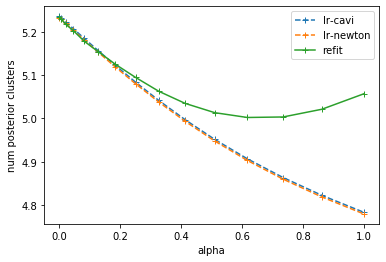

In [55]:
plt.plot(epsilon_vec, lr_e_num_clusters_vec, '+--', label = 'lr-cavi')
plt.plot(epsilon_vec, lr_newton_e_num_clusters_vec, '+--', label = 'lr-newton')

plt.plot(epsilon_vec, refit_e_num_clusters_vec, '+-', label = 'refit')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend()


### Number of predicted clusters

In [41]:
threshold = 0

lr_e_num_pred_clusters_vec = np.zeros(len(epsilon_vec))
refit_e_num_pred_clusters_vec = np.zeros(len(epsilon_vec))

for i in tqdm(range(len(epsilon_vec))): 
     # number of clusters as predicted by linear response
    lr_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(
        vb_params_paragami, 
        vb_pert_pred_array[i],
        n_obs = np.shape(features)[0], 
        threshold = threshold,
        n_samples = 100000)
    
    lr_e_num_pred_clusters_vec[i] = lr_e_num_pred_clusters
    
    # number of clusters after refitting 
    refit_e_num_pred_clusters = gmm_lib.get_e_num_pred_clusters_from_vb_free_params(
        vb_params_paragami, 
        vb_pert_opt_array[i],
        n_obs = np.shape(features)[0], 
        threshold = threshold,
        n_samples = 100000)
    
    refit_e_num_pred_clusters_vec[i] = refit_e_num_pred_clusters
    


100%|██████████| 15/15 [00:07<00:00,  1.90it/s]


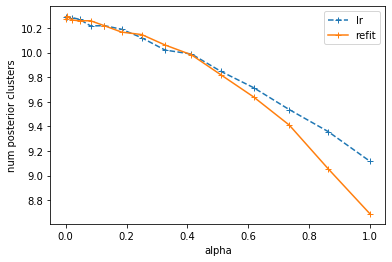

In [42]:
plt.plot(epsilon_vec, lr_e_num_pred_clusters_vec, '+--')
plt.plot(epsilon_vec, refit_e_num_pred_clusters_vec, '+-')

plt.xlabel('alpha')
plt.ylabel('num posterior clusters')
plt.legend(('lr', 'refit'))